**Imports**

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import heapq
import math
import random

In [2]:
# define function to draw the full graph

def draw(G):
    fig, ax = plt.subplots()
    G.to_directed()

    # Position the nodes using a spring layout
    pos = nx.spring_layout(G)

    #Get minimum spanning tree

   # mst = nx.minimum_spanning_tree(G, algorithm='prim')

    # Draw the random graph
    plt.figure(figsize=(20,20))
    nx.draw(G, pos=fixed_positions, with_labels=True, node_color='lightblue', font_weight='bold', ax=ax)
   # nx.draw(mst, pos=fixed_positions, with_labels=False, edge_color='red', width=2, ax=ax)

    # Display the plot
    ax.axis('on')
    plt.show()


# define function to draw the minimum spanning tree of the graph
def draw_mst(G):
    fig, ax = plt.subplots()

    # Position the nodes using a spring layout
    pos = nx.spring_layout(G)
#     fixed_positions = {'Base':(1,0), 1: (0.5, 1), 2: (0, 0.5), 3: (0.7, 2),
#                        4: (0.3, 3), 5:(1.3,1.5), 6:(2,2.7), 7:(2.5,4), 8:(2.8, 2.2), 9:(3.2, 3.4) }
    #Get minimum spanning tree

    mst = nx.minimum_spanning_tree(G, algorithm='prim')

    # Draw the random graph
    plt.figure(figsize=(20,20))
  #  nx.draw(G, pos=fixed_positions, with_labels=True, node_color='lightblue', font_weight='bold', ax=ax)
    nx.draw(mst, pos=fixed_positions, with_labels=True, edge_color='red', width=2, ax=ax)
   # nx.draw(mst, pos, with_labels=False, edge_color='green', width=1, ax=ax)
    # Display the plot
    ax.axis('on')
    plt.show()

# Function to find euclidean distance between nodes
def euclid_dist(G,node1, node2):
    pos1 = G.nodes[node1]['pos']
    pos2 = G.nodes[node2]['pos']
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def add_edge_weights(G):
    edges = list(G.edges)
    for node1, node2 in edges:
        dist = euclid_dist(G,node1, node2)
        G.add_edge(node1, node2, weight=dist)

In [3]:
# Create a graph.
G = nx.Graph()

# Add nodes to the graph.
G.add_nodes_from(list(range(1,10)))
G.add_node('Base')

#Fix the positions of the nodes on the graph
fixed_positions = {'Base':(5,3), 1: (2.5, 5.7), 2: (1, 4), 3: (3, 8),4: (1.9, 10.2), 5:(4.9,6.5),
                   6:(5.5,10), 7:(5.9,13.2), 8:(7, 9.5), 9:(9, 12) }

G.add_node('Base',pos=(5,3))
G.add_node(1,pos=(2.5, 5.7))
G.add_node(2,pos=(1, 4))
G.add_node(3,pos=(3, 8))
G.add_node(4,pos=(1.9, 10.2))
G.add_node(5,pos=(4.9,6.5))
G.add_node(6,pos=(5.5,10))
G.add_node(7,pos=(5.9,13.2))
G.add_node(8,pos=(7, 9.5))
G.add_node(9,pos=(9, 12))

# Add edges to the graph.
edges = [
    ('Base',1),
    ('Base',2),
    (1,2),
    (1,3),
    (1,5),
    (3,4),
    (3,6),
    (3,8),
    (3,5),
    (4,6),
    (5,8),
    (6,7),
    (6,8),
    (6,9),
    (7,9),
    (8,9)]

G.add_edges_from(edges)
add_edge_weights(G)

## Minimum spanning tree for the graph

In [4]:
mst = nx.minimum_spanning_tree(G,algorithm='prim')

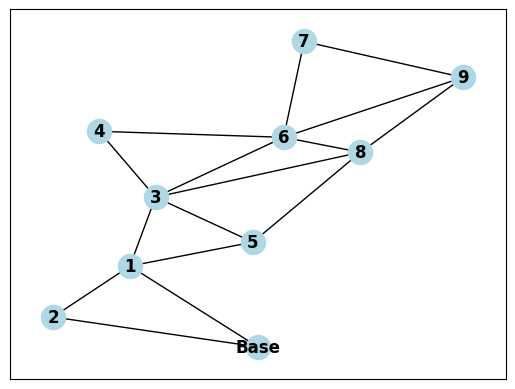

<Figure size 2000x2000 with 0 Axes>

In [5]:
draw(G)

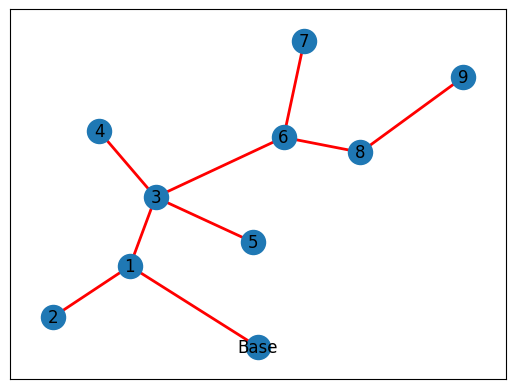

<Figure size 2000x2000 with 0 Axes>

In [6]:
draw_mst(G)

## Selecting Data Collection Points

In [7]:
def find_child_nodes(G, n):
    visited = [n]
    not_visited = []
    child_nodes = []

    # Exclude possible visited nodes
    if n !='Base':
        visited.append('Base')
        visited.extend(list(range(1,n)))

    # Find all child/successor nodes
    for node in G.neighbors(n):
        if node not in visited:
            visited.append(node)
            child_nodes.append(node)
            child_nodes.extend(find_child_nodes(G,node))

    # sort the list of successor nodes
    child_nodes.sort()
    return child_nodes

In [8]:
def calc_ndi(G, si):
    child_nodes = find_child_nodes(G, si)
    return len(child_nodes) + 1

In [9]:
def get_lambda_hop(G, P, si):
    # Get lenghts between all nodes.
    all_pairs_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    node = si

    # Traverse all nodes from si to Base
    while node != 'Base':
        dist = all_pairs_shortest_paths[node]['Base']

        # If neighbour is closer to Base check if it is already a collection point.
        for neighbor in G.neighbors(node):
            if all_pairs_shortest_paths[neighbor]['Base'] < dist:
                dist = all_pairs_shortest_paths[neighbor]['Base']
                node = neighbor

                # If traversal has reached the Base Station return 1 and distance from si to Base
                if dist == 0:
                    return 1, all_pairs_shortest_paths[si]['Base']

                # If traversal has found a collection point return 0 and distance from si to collection point
                if node in P:
                    return 0, all_pairs_shortest_paths[si][node]
    return None, None

In [10]:
def calc_omega(lam, H, ndi):
    return lam * H * ndi

def calc_Lmax(G):
    Lmax = 0

    # Retrieve edge weights for all edges and calculate maximum path lenght.
    for node1, node2, weight in list(G.edges.data()):
        Lmax+=weight['weight']
    return Lmax

In [11]:
# Getting an error in this code.

# Get the distance of nodes from the new path.
def distance_from_path(G, P, non_rooted_nodes, si):
    node_distances = {}
    position = {} #t
    edges = [] #t
    CPs = P.copy()
    nrn = non_rooted_nodes.copy()
    CPs.append(si)
    for cp in CPs[:-1]:
        start_node = cp
        end_node = CPs[CPs.index(cp) + 1]
        path_start = nx.get_node_attributes(G, 'pos')[start_node]
        path_end = nx.get_node_attributes(G, 'pos')[end_node]
        print(f"Checking for edge {start_node} and {end_node}")

        for node in nrn:
            node_pos = nx.get_node_attributes(G, 'pos')[node]
            distance = distance_point_to_line(node_pos, path_start, path_end)
            if distance < 5:
                nrn.remove(node)
                node_distances.update({(node, start_node, end_node) : distance})
                position.update({node:node_pos})
                edges.append((start_node, end_node))

    edges.append((start_node, end_node))
    graph = nx.Graph()
    graph.add_nodes_from(position.keys())
    graph.add_edges_from(edges)
    draw(graph, position)
    return node_distances

# Calculate euclidean distance between path and a node.
def distance_point_to_line(node_pos, path_start, path_end):
    x, y = node_pos
    x1, y1 = path_start
    x2, y2 = path_end

    A = y2 - y1
    B = x2 - x1
    C = (x2 * y1) - (x1 * y2)


    distance = abs((A * x) + (B * y) + C) / math.sqrt(A**2 + B**2)
    return distance


In [12]:
# Get the distance of nodes from the new path.


def distance_from_path(G, P, non_rooted_nodes, si):
    node_distances = {}
    CPs = P.copy()
    nrn = non_rooted_nodes.copy()
    CPs.append(si)
    for cp in CPs[:-1]:
        start_node = cp
        end_node = CPs[CPs.index(cp) + 1]
        path_start = nx.get_node_attributes(G, 'pos')[start_node]
        path_end = nx.get_node_attributes(G, 'pos')[end_node]
        print(f"Checking for edge ({start_node}, {end_node})")

        for node in nrn:
            node_pos = nx.get_node_attributes(G, 'pos')[node]
            distance = distance_point_to_line(node_pos, path_start, path_end)
            if distance < 1  and node not in P:
                nrn.remove(node)
                node_distances.update({(node, start_node, end_node) : distance})



    return node_distances

# Calculate euclidean distance between path and a node.
def distance_point_to_line(node_pos, path_start, path_end):
    x, y = node_pos
    x1, y1 = path_start
    x2, y2 = path_end

    A = y2 - y1
    B = x2 - x1
    C = (x2 * y1) - (x1 * y2)
   # print(f"{A},{B}")

    distance = abs((A * x) - (B * y) + C) / math.sqrt(A**2 + B**2)
    return distance


In [13]:
def get_Bi(node_distances):
    B = []
    for node in list(node_distances.keys()):
        B.append(node[0])

    return B

In [14]:
def closest_collection_points(G, P, si):
    min_dist = 999.99
    node = 0
    for cp in P:
        dist = euclid_dist(G, cp, si)
        if min_dist > dist:
            min_dist = dist
            node = cp
    return node

In [15]:
def calc_omega_j(G, Bi):
    s = 0
    for si in Bi:
        lam, H = get_lambda_hop(mst, P, si)
        ndi = calc_ndi(G, si)
        s += calc_omega(lam, H, ndi)
    return s

In [16]:
def calc_benefit_index(G, omega_i, sum_omega_j, closest_cp_dist):
    bi = (omega_i + sum_omega_j)/ closest_cp_dist
    return bi

Energy-Aware Path:
((0, 0), 15)
(15, 3)
(3, 10)
(10, 17)
(17, 4)
(4, 1)
(1, 8)
(8, 12)
(12, 16)
(16, 13)
(13, 2)
(2, 18)
(18, 0)
(0, 9)
(9, 14)
(14, 11)
(11, 6)
(6, 19)
(19, 7)
(7, 5)


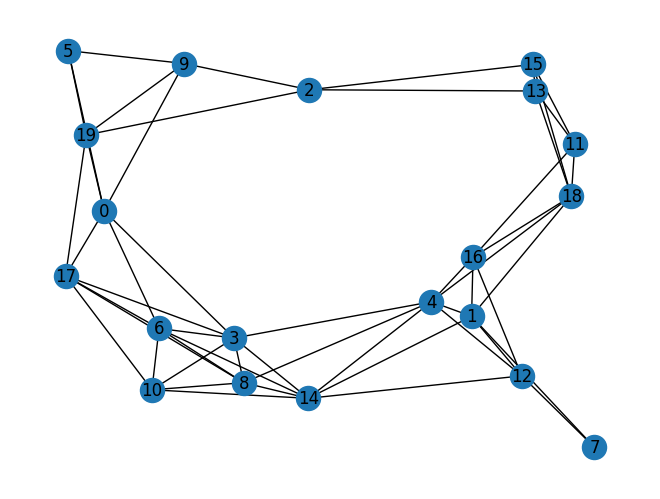

In [17]:
def initialize_network(num_nodes):
    G = nx.random_geometric_graph(num_nodes, 0.4)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True)
    return G

def calculate_energy(node):
    # Placeholder function for calculating node energy

    return random.uniform(2.0, 1.0)

def energy_aware_path_construction(G, mobile_sink_position):
    path = []
    current_position = mobile_sink_position

    while G.number_of_nodes() > 0:
        energies = {node: calculate_energy(node) for node in G.nodes}
        sorted_nodes = sorted(energies, key=energies.get, reverse=True)

        next_node = sorted_nodes[0]
        path.append((current_position, next_node))

        current_position = next_node
        G.remove_node(next_node)

    return path

def main():
    num_nodes = 20
    mobile_sink_position = (0, 0)

    G = initialize_network(num_nodes)
    path = energy_aware_path_construction(G, mobile_sink_position)

    print("Energy-Aware Path:")
    for edge in path:
        print(edge)

    plt.show()

if __name__ == "__main__":
    main()


In [18]:
def calc_distance(nodes, distances):


    distance = distances[nodes[0], nodes[1]]
    return distance


def calc_total_energy(nodes, distances, path):

    total_energy = 0
    for i in range(1, len(path)):
        distance = calc_distance(nodes, distances, path[i - 1:i + 1])
        total_energy += distance * (1 + 0.1 * distance)
    return total_energy


def construct_mst(nodes, distances):


    visited = [False] * len(nodes)
    current_node = 0
    mst = []

    while not all(visited):
        visited[current_node] = True

        for i, node in enumerate(nodes):
            if not visited[i]:
                distance = distances[current_node, i]
                if distance < min_distance:
                    min_distance = distance
                    next_node = i

        mst.append((current_node, next_node))
        current_node = next_node

    return mst


def select_collection_point(nodes, distances, mst, min_distance, max_distance):


    best_next_point = None
    best_coverage_distance = -1

    for edge in mst:
        node1, node2 = edge

        # Check if either node is already a collection point
        if node1 in collection_points or node2 in collection_points:
            continue

        # Calculate the coverage distance
        coverage_distance = max_distance - calc_distance(nodes, distances, (node1, node2))

        # Check if the coverage distance is valid
        if coverage_distance < 0:
            continue

        # Update the best next point and coverage distance if necessary
        if coverage_distance > best_coverage_distance:
            best_next_point = node1
            best_coverage_distance = coverage_distance

    return best_next_point


def construct_path(nodes, distances, collection_points):


    path = []
    current_point = 0

    while collection_points:
        best_next_point = select_collection_point(nodes, distances, mst, min_distance, max_distance)
        path.append(best_next_point)
        collection_points.remove(best_next_point)
        current_point = best_next_point

    path.append(current_point)
    return path



In [19]:
def construct_mst(nodes, distances, region):
    visited = [False] * len(nodes)
    current_node = region[0]
    mst = []

    while not all(visited):
        min_distance = float('inf')  # Initialize min_distance before the loop

        visited[current_node] = True

        for i, node in enumerate(nodes):
            if not visited[i] and node in region:
                distance = distances[current_node, i]
                if distance < min_distance:
                    min_distance = distance
                    next_node = i

        mst.append((current_node, next_node))
        current_node = next_node

    return mst


In [20]:
def calc_avg_mst_length(nodes, distances, regions):
    total_length = 0
    total_edges = 0

    for region in regions:
        region_nodes = set(region)
        for edge in construct_mst(nodes, distances, region_nodes):
            total_length += distances[edge[0], edge[1]]
            total_edges += 1

    if total_edges == 0:
        return 0
    return total_length / total_edges


In [21]:
l = list(nx.get_node_attributes(G, 'pos').values())

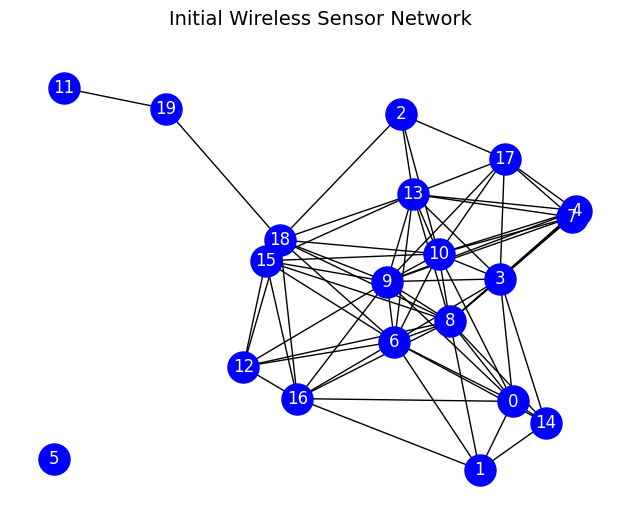

Renumbered Path: [(0.8428338308108665, 0.5109889652962335), (0.02278245615766228, 0.06471512703045734), (0.43859402755440324, 0.6078271379262841), (0.9827234360138211, 0.6799668720696703), (0.04160653909358203, 0.9831822841439135), (0.9742376443943803, 0.6638366595184619), (0.851038428992246, 0.8086332470082683), (0.3712399354523871, 0.29380263903817216), (0.228685017088065, 0.9320329194792926), (0.7298424824442021, 0.5729959772287672), (0.4704802637556319, 0.21467767781450864), (0.6489093465720159, 0.35553632515458633), (0.660379248382181, 0.9187749312191307), (0.7507255544264443, 0.40581380763122443), (0.9268823923302051, 0.15443831772084915), (0.41277237274373324, 0.5558122391345485), (0.8051713874093283, 0.03827046100308895), (0.6351872760821655, 0.5042585726272752), (0.6829346656136372, 0.7207140332379902), (0.8666898365361355, 0.2078120363963114)]


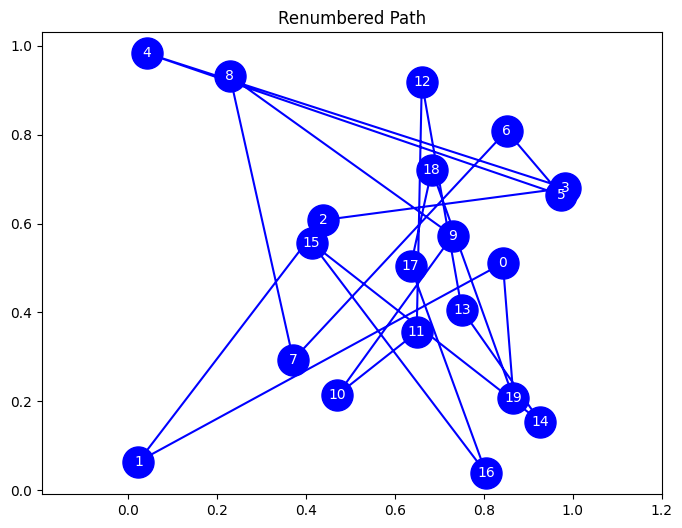

Energy-Aware Path:
((0, 0), 18)
(18, 5)
(5, 9)
(9, 16)
(16, 17)
(17, 1)
(1, 11)
(11, 7)
(7, 2)
(2, 4)
(4, 3)
(3, 19)
(19, 6)
(6, 10)
(10, 0)
(0, 12)
(12, 15)
(15, 13)
(13, 8)
(8, 14)


In [22]:
import numpy as np

def path_construction_algorithm(P):
    # Initialization
    Pinit = [P[0]]  # pˆ0 = p0
    p_hat_turn = P[0]
    i = 1

    while p_hat_turn != P[0]:
        # Let l be a horizontal line passing through pˆturn
        l = [p_hat_turn[0], p_hat_turn[1]]

        # Turn l in a counterclockwise direction until it touches any CP pj
        l[0] += 1  # Assuming the line moves in the x-direction
        for pj in P:
            if pj[0] == l[0] and pj[1] >= l[1]:
                p_hat_i = pj
                Pinit.append(p_hat_i)
                p_hat_turn = p_hat_i
                i += 1
                break

    Pinternal = set(P) - set(Pinit)

    while Pinternal:
        # Compute pcl according to Equ. (18)
        pcl = compute_pcl(Pinternal)

        # Remove edge (pˆi, pˆi+1)
        Pinit.pop(-1)

        # Connect point pcl to points pi and pi+1
        Pinit.extend([pcl, p_hat_turn])

        # Update Pinternal
        Pinternal = Pinternal - {pcl}

    LP = renumbered(Pinit)
    return LP

def compute_pcl(Pinternal):
    # Placeholder function for computing pcl
    # Replace this with your specific calculation
    pcl = list(Pinternal)[0]
    return pcl

def renumbered(P):
    # Placeholder function for renumbering the path
    # Replace this with your specific renumbering logic
    return P

def initialize_network(num_nodes):
    G = nx.random_geometric_graph(num_nodes, 0.4)
    pos = nx.get_node_attributes(G, 'pos')

    plt.figure(figsize=(8, 6))
    plt.text(0.5, 1.05, "Initial Wireless Sensor Network", horizontalalignment='center', fontsize=14, transform=plt.gca().transAxes)

    # Draw nodes with increased size and add labels inside nodes
    nx.draw(G, pos, node_color='blue', node_size=500)  # Large enough for visibility
    labels = {i: i for i in range(num_nodes)}
    nx.draw_networkx_labels(G, pos, labels, font_color='white')

    plt.show()

    # Convert positions to tuples for further processing
    converted_dict = {key: tuple(value) for key, value in pos.items()}
    positions = list(converted_dict.values())
    return G, positions

def calculate_energy(node):
    # Placeholder function for calculating node energy

    return random.uniform(2.0, 1.0)

def energy_aware_path_construction(G, mobile_sink_position):
    path = []
    current_position = mobile_sink_position

    while G.number_of_nodes() > 0:
        energies = {node: calculate_energy(node) for node in G.nodes}
        sorted_nodes = sorted(energies, key=energies.get, reverse=True)

        next_node = sorted_nodes[0]
        path.append((current_position, next_node))

        current_position = next_node
        G.remove_node(next_node)

    return path


def algo_2(P):
    LP = path_construction_algorithm(P)
    print("Renumbered Path:", LP)

    # Visualization (plotting the path)
    LP.append(LP[0])  # Closing the loop
    LP = np.array(LP)

    plt.figure(figsize=(8, 6))
    plt.title("Renumbered Path")

    # Plot points and annotate them with numbers inside markers
    for i, (x, y) in enumerate(LP[:-1]):  # Skip the last one as it's a duplicate of the first
        plt.scatter(x, y, color='blue', s=500)  # Same size as initial graph
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0,0), ha='center', va='center', color='white')

    # Connect points with lines
    plt.plot(LP[:, 0], LP[:, 1], color='blue')

    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()



def main():
    num_nodes = 20
    mobile_sink_position = (0, 0)

    G, positions = initialize_network(num_nodes)
    path = energy_aware_path_construction(G, mobile_sink_position)
    algo_2(positions)


    print("Energy-Aware Path:")
    for edge in path:
        print(edge)

    plt.show()

if __name__ == "__main__":
    main()


Part 2 --> Finding the minimum nuber of mobile sinks

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np

In [24]:
#Algorithm 2
def clustering(V, k):
  # Perform k-means clustering
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(V)

  # Get the cluster centers and labels
  cluster_centers = kmeans.cluster_centers_
  cluster_labels = kmeans.labels_

  # Plot the clustered nodes with different colors for each cluster
  plt.figure()
  for i in range(k):
      cluster_nodes = node_positions[cluster_labels == i]
      plt.scatter(cluster_nodes[:, 0], cluster_nodes[:, 1], label=f'Cluster {i+1}')
  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', label='Centroids')
  plt.title('Clustered Nodes')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.legend()
  plt.show()

  return cluster_centers, cluster_labels

In [25]:
# Algorithm 3
def perfect_matching(subgraph):
    odd_degree_nodes = [node for node, degree in subgraph.degree() if degree % 2 != 0]

    if len(odd_degree_nodes) < 2:
        return None

    matching_edges = nx.max_weight_matching(subgraph)

    return matching_edges

In [26]:
# Algorithm 4
def hierholzer_algorithm(graph):
    def dfs(v):
        nonlocal path
        while adj_list[v]:
            u = adj_list[v].pop()  # Get the next neighbor
            dfs(u)
        path.append(v)  # Append the node when the recursion unwinds

    # Create adjacency list
    adj_list = {v: list(graph.neighbors(v)) for v in graph}

    # Find starting vertex
    start_vertex = next(iter(graph))

    # Initialize Eulerian path
    path = []

    # Run Hierholzer's algorithm
    dfs(start_vertex)

    # Reverse the path to get the correct order
    path.reverse()

    return path



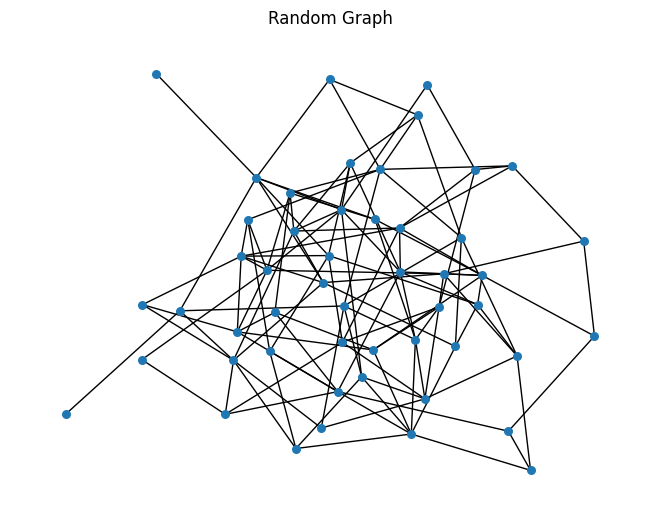

In [27]:
# Algorithm 1
#Create Graph
# Generate a random graph with about 50 nodes
G = nx.erdos_renyi_graph(50, 0.1)  # Adjust parameters as needed

# Plot the graph
pos = nx.spring_layout(G)  # Position nodes using the Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=False, node_size=30)
plt.title('Random Graph')
plt.show()
# Extract node coordinates
node_positions = np.array([pos[node] for node in G.nodes()])

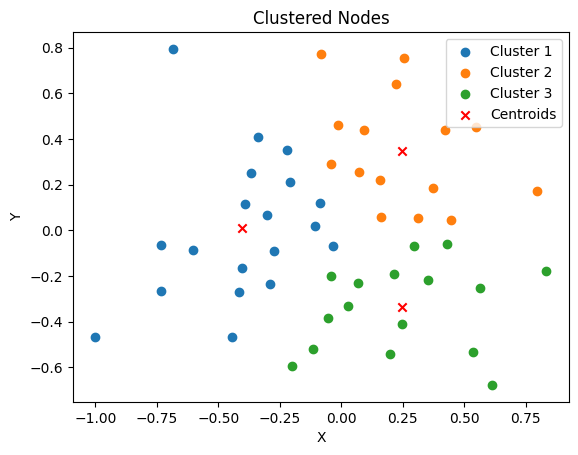

In [28]:
# Call clustering function (Algorithm 2)
k = 3
centers, labels = clustering(node_positions, k)

Cluster 1:
Nodes: [ 1  6  7  9 11 16 17 19 23 24 26 29 37 38 39 40 44 46 47]
Minimum Spanning Tree Edges: [(np.int64(1), 39), (np.int64(1), 47), (np.int64(6), 9), (np.int64(6), 16), (np.int64(6), 23), (np.int64(6), 24), (np.int64(7), 23), (np.int64(11), 17), (np.int64(11), 46), (np.int64(16), 26), (np.int64(16), 29), (np.int64(16), 46), (np.int64(17), 37), (np.int64(19), 23), (np.int64(24), 38), (np.int64(26), 40), (np.int64(26), 44), (np.int64(26), 47)]
Node Degrees: {np.int64(1): 2, np.int64(6): 4, np.int64(7): 1, np.int64(9): 1, np.int64(11): 2, np.int64(16): 4, np.int64(17): 2, np.int64(19): 1, np.int64(23): 4, np.int64(24): 3, np.int64(26): 6, np.int64(29): 3, np.int64(37): 5, np.int64(38): 2, np.int64(39): 3, np.int64(40): 3, np.int64(44): 3, np.int64(46): 5, np.int64(47): 4}


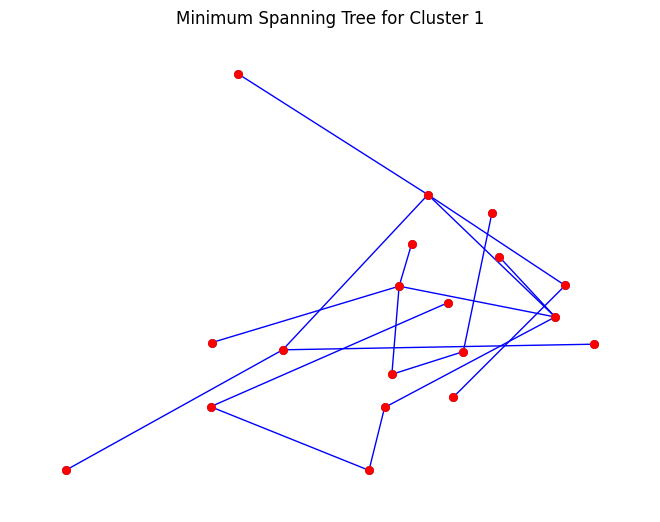

Perfect Matching Edges: {(np.int64(47), np.int64(40)), (np.int64(44), 26), (6, 9), (np.int64(29), 16), (np.int64(23), np.int64(19)), (1, 39), (np.int64(38), 24), (np.int64(37), 17), (np.int64(46), 11)}
Eulerian Path: [np.int64(1), 47, np.int64(40), np.int64(47), np.int64(26), 44, np.int64(26), 40, np.int64(26), np.int64(16), 46, np.int64(11), 17, 37, np.int64(17), np.int64(11), 46, np.int64(16), 29, np.int64(16), np.int64(6), 24, 38, np.int64(24), np.int64(6), 23, np.int64(19), 23, np.int64(7), 23, np.int64(6), 9, np.int64(6), 16, 26, 47, np.int64(1), 39, np.int64(1)]
Length of Eulerian Path: 39
+=====================+
[(np.int64(1), 47), (47, np.int64(40)), (np.int64(40), np.int64(47)), (np.int64(47), np.int64(26)), (np.int64(26), 44), (44, np.int64(26)), (np.int64(26), 40), (40, np.int64(26)), (np.int64(26), np.int64(16)), (np.int64(16), 46), (46, np.int64(11)), (np.int64(11), 17), (17, 37), (37, np.int64(17)), (np.int64(17), np.int64(11)), (np.int64(11), 46), (46, np.int64(16)), (np

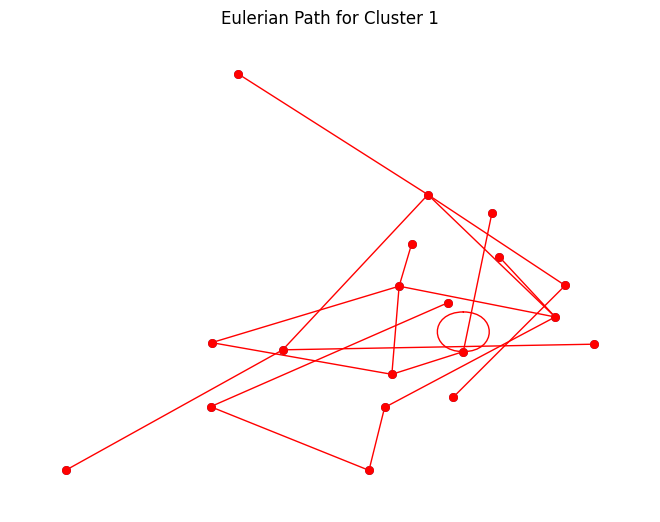

Cluster 2:
Nodes: [ 2  3 10 15 21 25 28 32 33 34 36 42 43 45 49]
Minimum Spanning Tree Edges: [(np.int64(32), 10), (np.int64(32), 36), (np.int64(32), 43), (np.int64(32), 45), (np.int64(33), 42), (np.int64(33), 45), (np.int64(2), 3), (np.int64(2), 34), (np.int64(3), 10), (np.int64(3), 28), (np.int64(42), 15), (np.int64(15), 21), (np.int64(15), 25), (np.int64(15), 49)]
Node Degrees: {np.int64(32): 4, np.int64(33): 2, np.int64(2): 2, np.int64(3): 3, np.int64(34): 3, np.int64(36): 4, np.int64(10): 4, np.int64(42): 4, np.int64(43): 1, np.int64(45): 2, np.int64(15): 4, np.int64(49): 2, np.int64(21): 2, np.int64(25): 4, np.int64(28): 3}


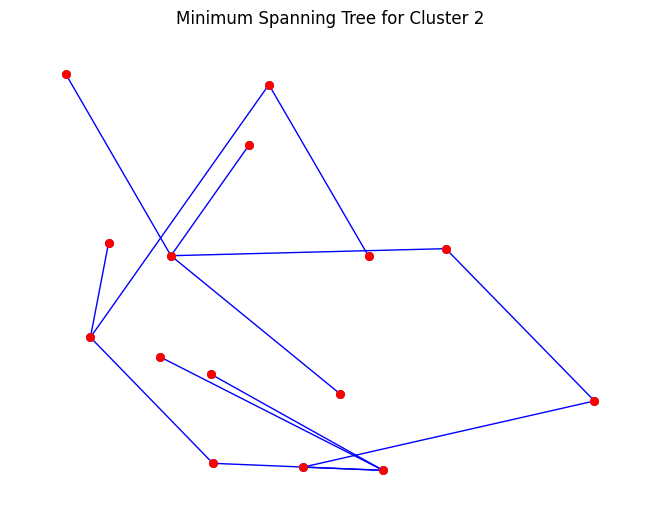

Perfect Matching Edges: {(15, np.int64(49)), (33, np.int64(45)), (32, np.int64(43)), (np.int64(28), 3), (np.int64(10), 36), (np.int64(25), np.int64(21)), (42, 34)}
Eulerian Path: [np.int64(32), 45, np.int64(33), 45, np.int64(32), 43, np.int64(32), 36, np.int64(10), np.int64(36), np.int64(32), 10, np.int64(3), 28, np.int64(3), np.int64(2), 34, 42, 15, 49, np.int64(15), 25, np.int64(21), np.int64(25), np.int64(15), 21, np.int64(15), np.int64(42), np.int64(33), 42, np.int64(34), np.int64(2), 3, 10, np.int64(32)]
Length of Eulerian Path: 35
+=====================+
[(np.int64(32), 45), (45, np.int64(33)), (np.int64(33), 45), (45, np.int64(32)), (np.int64(32), 43), (43, np.int64(32)), (np.int64(32), 36), (36, np.int64(10)), (np.int64(10), np.int64(36)), (np.int64(36), np.int64(32)), (np.int64(32), 10), (10, np.int64(3)), (np.int64(3), 28), (28, np.int64(3)), (np.int64(3), np.int64(2)), (np.int64(2), 34), (34, 42), (42, 15), (15, 49), (49, np.int64(15)), (np.int64(15), 25), (25, np.int64(21))

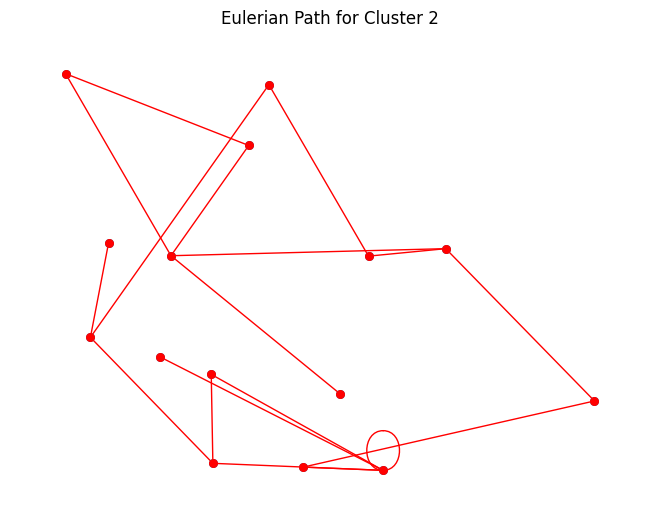

Cluster 3:
Nodes: [ 0  4  5  8 12 13 14 18 20 22 27 30 31 35 41 48]
Minimum Spanning Tree Edges: [(np.int64(0), 5), (np.int64(0), 27), (np.int64(35), 8), (np.int64(35), 14), (np.int64(4), 5), (np.int64(4), 20), (np.int64(4), 30), (np.int64(5), 8), (np.int64(8), 12), (np.int64(8), 13), (np.int64(8), 22), (np.int64(41), 12), (np.int64(14), 18), (np.int64(48), 30), (np.int64(20), 31)]
Node Degrees: {np.int64(0): 2, np.int64(35): 2, np.int64(4): 3, np.int64(5): 3, np.int64(8): 6, np.int64(41): 2, np.int64(12): 3, np.int64(13): 3, np.int64(14): 4, np.int64(48): 1, np.int64(18): 2, np.int64(20): 7, np.int64(22): 1, np.int64(27): 2, np.int64(30): 3, np.int64(31): 2}


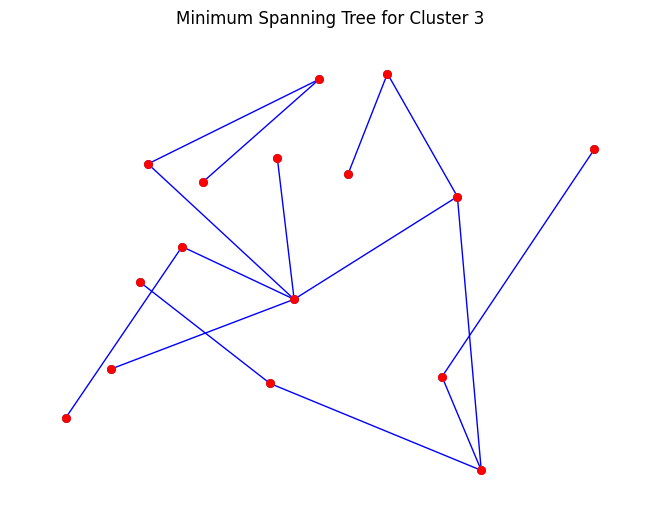

Perfect Matching Edges: {(np.int64(22), 8), (np.int64(31), 20), (4, 5), (np.int64(30), np.int64(48)), (np.int64(12), 41), (np.int64(27), 0), (np.int64(18), 14)}
Eulerian Path: [np.int64(0), 27, np.int64(0), 5, 8, 22, np.int64(8), 13, np.int64(8), 12, np.int64(41), 12, np.int64(8), np.int64(35), 14, 18, np.int64(14), np.int64(35), 8, np.int64(5), np.int64(4), 30, np.int64(48), 30, np.int64(4), 20, 31, np.int64(20), np.int64(4), 5, np.int64(0)]
Length of Eulerian Path: 31
+=====================+
[(np.int64(0), 27), (27, np.int64(0)), (np.int64(0), 5), (5, 8), (8, 22), (22, np.int64(8)), (np.int64(8), 13), (13, np.int64(8)), (np.int64(8), 12), (12, np.int64(41)), (np.int64(41), 12), (12, np.int64(8)), (np.int64(8), np.int64(35)), (np.int64(35), 14), (14, 18), (18, np.int64(14)), (np.int64(14), np.int64(35)), (np.int64(35), 8), (8, np.int64(5)), (np.int64(5), np.int64(4)), (np.int64(4), 30), (30, np.int64(48)), (np.int64(48), 30), (30, np.int64(4)), (np.int64(4), 20), (20, 31), (31, np.int

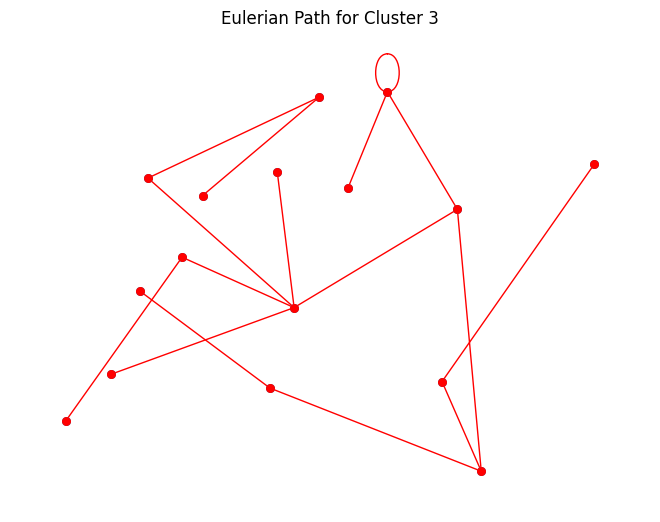

In [29]:
k = 3
for i in range(k):
    cluster_nodes = np.array(G.nodes())[labels == i]

    # Create a subgraph containing only nodes from the current cluster
    subgraph = G.subgraph(cluster_nodes)

    # Calculate the minimum spanning tree for the subgraph
    mst = nx.minimum_spanning_tree(subgraph)

    # Find the degree of each node in the cluster
    node_degrees = dict(subgraph.degree())

    print(f"Cluster {i+1}:")
    print("Nodes:", cluster_nodes)
    print("Minimum Spanning Tree Edges:", mst.edges())
    print("Node Degrees:", node_degrees)

    # Plot the minimum spanning tree
    plt.figure()
    nx.draw(mst, pos, with_labels=False, node_size=30, edge_color='b')
    nx.draw_networkx_nodes(subgraph, pos, nodelist=cluster_nodes, node_color='r', node_size=30)
    plt.title(f'Minimum Spanning Tree for Cluster {i+1}')
    plt.show()

    # Implement perfect matching if at least one node has an odd degree
    matching_edges = perfect_matching(subgraph)
    if matching_edges:
        print("Perfect Matching Edges:", matching_edges)

        # Add the matching edges to the minimum spanning tree
        mst.add_edges_from(matching_edges)

        # Calculate Eulerian path and its length
        eulerian_path = hierholzer_algorithm(nx.MultiGraph(mst))
        eulerian_path_length = len(eulerian_path)

        print("Eulerian Path:", eulerian_path)
        print("Length of Eulerian Path:", eulerian_path_length)

        # Construct edges from the Eulerian path
        eulerian_edges = [(eulerian_path[i], eulerian_path[i+1]) for i in range(len(eulerian_path)-1)]
        eulerian_edges.append((eulerian_path[-1], eulerian_path[0]))  # Add edge to close the Eulerian path

        # Plot Eulerian path on the graph
        print("+=====================+")
        print(eulerian_edges)
        print("+=====================+")
        eulerian_graph = nx.Graph(eulerian_edges)
        plt.figure()
        nx.draw(eulerian_graph, pos, with_labels=False, node_size=30, edge_color='r')
        nx.draw_networkx_nodes(subgraph, pos, nodelist=cluster_nodes, node_color='r', node_size=30)
        plt.title(f'Eulerian Path for Cluster {i+1}')
        plt.show()

In [30]:
total_length = 0

# Iterate through each cluster
for i in range(k):
    cluster_nodes = np.array(G.nodes())[labels == i]

    # Create a subgraph containing only nodes from the current cluster
    subgraph = G.subgraph(cluster_nodes)

    # Calculate the total length of all edges in the cluster
    cluster_length = subgraph.number_of_edges()

    # Print the total length of the cluster
    print(f"Total Length of Edges in Cluster {i+1}: {cluster_length}")

    # Add the cluster length to the total length across all clusters
    total_length += cluster_length

# Print the total length across all clusters
print(f"Total Length Across All Clusters: {total_length}")


Total Length of Edges in Cluster 1: 29
Total Length of Edges in Cluster 2: 22
Total Length of Edges in Cluster 3: 23
Total Length Across All Clusters: 74


In [31]:
import random
import time

def time_taken():
    return random.randint(1, 120)

def clustering(V, bt):
    k = 0
    flag = 0
    for ci in V:
        t_ci = time_taken()  # Time taken for cluster ci
        print(f"Cluster {ci} took {t_ci} seconds.")
        if t_ci > bt:
            k += 1
            flag = 0
        else:
            flag = 1

    if flag == 1:
        return k
    else:
        k += 1
        return clustering(V, k)

# Example usage
V = [1, 2, 3]  # Example clusters
bt = 30  # Example threshold

result = clustering(V, bt)
print(f"Result: {result}")


Cluster 1 took 28 seconds.
Cluster 2 took 38 seconds.
Cluster 3 took 23 seconds.
Result: 1


In [32]:
#Params
ms_speed = np.random.randint(100)

#distance
travel_distance_one_sink = 400
travel_distance_multi_sink = 180
travel_distance_AADTMS = 500
travel_distance_SPCBT = 700

#Get travel time
travel_time_one_sink = travel_distance_one_sink/ ms_speed
travel_time_multi_sink = travel_distance_multi_sink/ ms_speed
travel_time_AADTMS = travel_distance_AADTMS/ ms_speed
travel_time_SPCBT = travel_distance_SPCBT/ ms_speed

#Get Joules consumed
ACO_energy_consumption = 58
DBrKM = 60
without_optimisation_energy_consumption = 75
EATC = 50


performance_metrics = {
    "Total Distance Travelled": [travel_distance_one_sink, travel_distance_multi_sink, travel_distance_AADTMS, travel_distance_SPCBT],
    "Energy Consumed": [ACO_energy_consumption, DBrKM, without_optimisation_energy_consumption, EATC],
    "Time traveled": [travel_time_one_sink, travel_time_multi_sink, travel_time_AADTMS, travel_time_SPCBT]
}



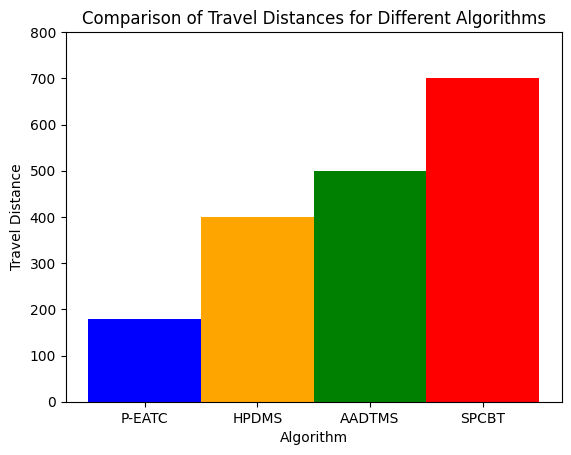

In [33]:
# Define the labels and corresponding distances
labels = ['P-EATC', 'HPDMS', 'AADTMS', 'SPCBT']
distances = [travel_distance_multi_sink, travel_distance_one_sink, travel_distance_AADTMS, travel_distance_SPCBT]

# Plotting the bar graph
plt.bar(labels, distances, width=1.0 ,color=['blue', 'orange','green','red'])

# Adding labels and title
plt.xlabel('Algorithm')
plt.ylabel('Travel Distance')
plt.title('Comparison of Travel Distances for Different Algorithms')
plt.ylim(0, max(distances) + 100)  # Adjusting y-axis limit for better visualization

# Displaying the plot
plt.show()

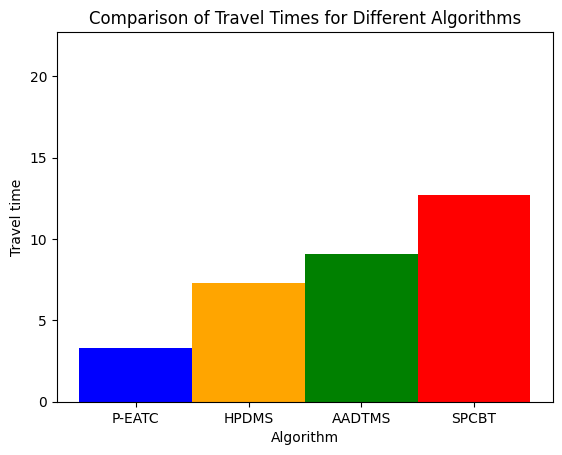

In [34]:
# Define the labels and corresponding distances
labels = ['P-EATC', 'HPDMS', 'AADTMS', 'SPCBT']
distances = [travel_time_multi_sink, travel_time_one_sink, travel_time_AADTMS, travel_time_SPCBT]

# Plotting the bar graph
plt.bar(labels, distances, width=1.0, color=['blue', 'orange','green','red'])

# Adding labels and title
plt.xlabel('Algorithm')
plt.ylabel('Travel time')
plt.title('Comparison of Travel Times for Different Algorithms')
plt.ylim(0, max(distances) + 10)  # Adjusting y-axis limit for better visualization

# Displaying the plot
plt.show()

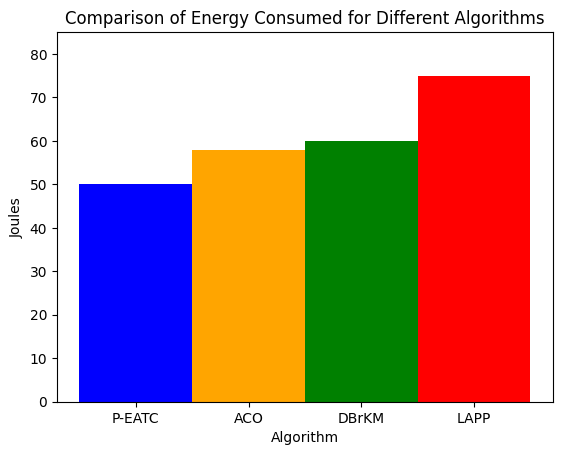

In [35]:
# Define the labels and corresponding distances
labels = ['P-EATC', 'ACO', 'DBrKM', 'LAPP']
distances = [EATC, ACO_energy_consumption, DBrKM, without_optimisation_energy_consumption]

# Plotting the bar graph
plt.bar(labels, distances,width=1.0, color=['blue', 'orange','green','red'])

# Adding labels and title
plt.xlabel('Algorithm')
plt.ylabel('Joules')
plt.title('Comparison of Energy Consumed for Different Algorithms')
plt.ylim(0, max(distances) + 10)  # Adjusting y-axis limit for better visualization

# Displaying the plot
plt.show()

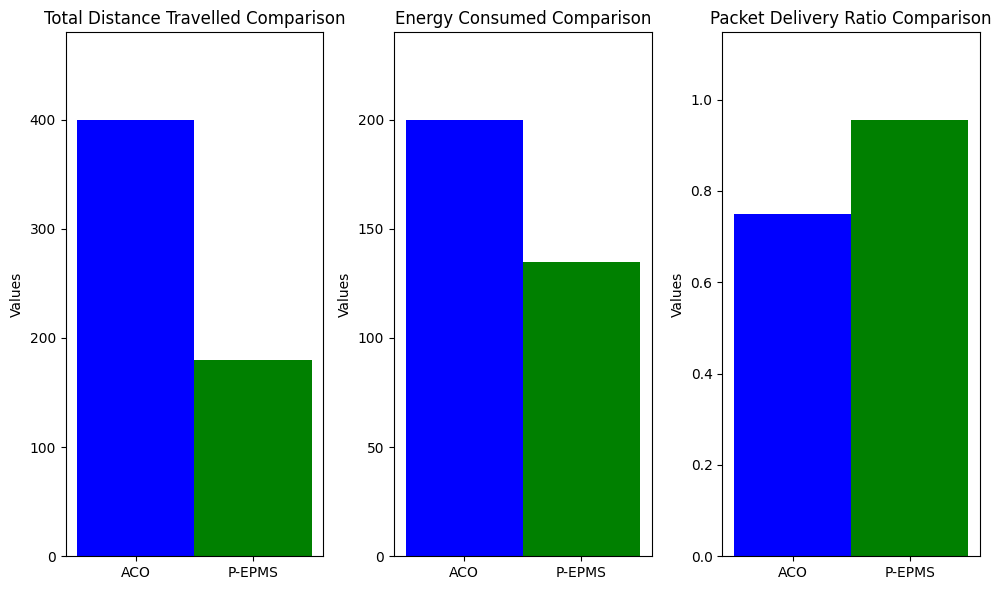

Efficiency Improvement in Packet Delivery Ratio: 27.47%


In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
area_size = (100, 100)  # Area size
num_sensors = 60  # Number of sensors
travel_distance_one_sink = 400  # Hypothetical travel distance for one sink
travel_distance_multi_sink = 180  # Hypothetical travel distance for multiple sinks
energy_per_unit_distance = 0.5  # Energy consumed per unit distance traveled
packet_delivery_ratio_one_sink = 0.75  # Packet delivery ratio with one sink
packet_delivery_ratio_multi_sink = 0.956  # Packet delivery ratio with multiple sinks

height = 6
width = 10

# Simulation of energy consumed
energy_consumed_one_sink = travel_distance_one_sink * energy_per_unit_distance
energy_consumed_multi_sink = travel_distance_multi_sink * energy_per_unit_distance * 1.5

# Performance metrics dictionary
performance_metrics = {
    "Total Distance Travelled": [travel_distance_one_sink, travel_distance_multi_sink],
    "Energy Consumed": [energy_consumed_one_sink, energy_consumed_multi_sink],
    "Packet Delivery Ratio": [packet_delivery_ratio_one_sink, packet_delivery_ratio_multi_sink]
}

# Efficiency calculation
efficiency_improvement = ((packet_delivery_ratio_multi_sink - packet_delivery_ratio_one_sink) /
                          packet_delivery_ratio_one_sink) * 100

# Plotting
fig, axes = plt.subplots(1, len(performance_metrics), figsize=(width, height))

for idx, (metric, values) in enumerate(performance_metrics.items()):
    x_labels = np.arange(2)  # Two bars: one for each sink configuration
    bar_width = 1.0

    axes[idx].bar(x_labels, values, width=bar_width, color=['blue', 'green'])
    axes[idx].set_title(f"{metric} Comparison")
    axes[idx].set_ylabel('Values')
    axes[idx].set_xticks(x_labels)
    axes[idx].set_xticklabels(["ACO", "P-EPMS"])
    axes[idx].set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()

print(f"Efficiency Improvement in Packet Delivery Ratio: {efficiency_improvement:.2f}%")
